In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pyuvdata import UVBeam

from astropy import units

### Don't forget to change the following cell to wherever you saved the beams

In [2]:
beam_path = ''

### Loading the beams

In [3]:
beam1 = UVBeam.from_file(os.path.join(beam_path,'beam1.fits'))
beam2 = UVBeam.from_file(os.path.join(beam_path,'beam2.fits'))

### The `UVBeam` class

The most important attribute of a `UVBeam` instance is `UVBeam.data_array`. It's a complex-valued numpy array representing the E-field beam, and generally has shape `(N_components, N_pols, N_freqs, N_axes2 (theta), N_axes1 (phi))`. If it's in Healpix coordinates, the last two dimensions collapsed into a single `N_pixels`, but that's not the case for the beams I sent you.

In our case, the size of those dimensions are:
 - `N_components`: 2, because there are two components to the E-field (theta and phi). It is possible to convert the beam to power units, in which case this dimension reduces to size 1.
 - `N_pols`: 1, because I saved the two polarization planes as separate beam files. But I could have also saved `beam1.fits` and `beam2.fits` as a single `UVBeam` object and this dimension would index either beam. Since this dimension has size 1, we'll always set that index to 0 (or use `np.squeeze`).
 - `N_freqs`: 49, because I simulated the frequencies from 0.3 to 1.5 GHz inclusively, at 0.025-GHz intervals. Let me know if you need a finer resolution!
 - `N_axes2 (theta)`: 181, because $\theta$ ranges from 0 deg (zenith) to 180 deg (nadir) inclusively, at 1-degree intervals. Let me know if you need a finer resolution!
 - `N_axes1 (phi)`: 360, because $\phi$ goes from 0 to 360 deg exclusively (since $\phi$=360 is the same as $\phi$=0 degrees).

So we have:

In [4]:
print(beam1.data_array.shape)
print(beam2.data_array.shape)

(2, 1, 49, 181, 360)
(2, 1, 49, 181, 360)


Other useful attributes include the array containing the frequencies; note they're in Hz.

In [5]:
print(beam1.freq_array)

[3.000e+08 3.250e+08 3.500e+08 3.750e+08 4.000e+08 4.250e+08 4.500e+08
 4.750e+08 5.000e+08 5.250e+08 5.500e+08 5.750e+08 6.000e+08 6.250e+08
 6.500e+08 6.750e+08 7.000e+08 7.250e+08 7.500e+08 7.750e+08 8.000e+08
 8.250e+08 8.500e+08 8.750e+08 9.000e+08 9.250e+08 9.500e+08 9.750e+08
 1.000e+09 1.025e+09 1.050e+09 1.075e+09 1.100e+09 1.125e+09 1.150e+09
 1.175e+09 1.200e+09 1.225e+09 1.250e+09 1.275e+09 1.300e+09 1.325e+09
 1.350e+09 1.375e+09 1.400e+09 1.425e+09 1.450e+09 1.475e+09 1.500e+09]


And the array containing the coordinate axes; note they're in radians.

In [6]:
print('Phi:')
print(beam1.axis1_array[:10],'...')
print(np.degrees(beam1.axis1_array[:10]),'...')

print('Theta:')
print(beam1.axis2_array[:10],'...')
print(np.degrees(beam2.axis1_array[:10]),'...')

Phi:
[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963] ...
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] ...
Theta:
[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963] ...
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] ...


Here's a link to the docs with the attributes: https://pyuvdata.readthedocs.io/en/latest/uvbeam.html#attributes

Then you also have useful methods. For instance, you may want to beam in power units:

In [7]:
beam1_power = beam1.efield_to_power(inplace=False)
beam2_power = beam2.efield_to_power(inplace=False)


In [8]:
beam1_power.data_array.shape

(1, 1, 49, 181, 360)

Importantly, note the `inplace` argument; default is `inplace = True`, in which case the converted beam overwrites your existing object.

Other useful methods include converting the beam to Healpix coordinates, converting to pseudo-stokes, computing the beam area or square area, peak normalizing, and more. Note that many of those only work if the beam has already been converted to power.
Here's a link the the docs with the methods: https://pyuvdata.readthedocs.io/en/latest/uvbeam.html#pyuvdata.UVBeam

Lastly, let's look at some beams! Let's compare `beam1` and `beam2`, in peak-normalized power units. Note that for those feeds, the peak is often not at $\theta=0$.

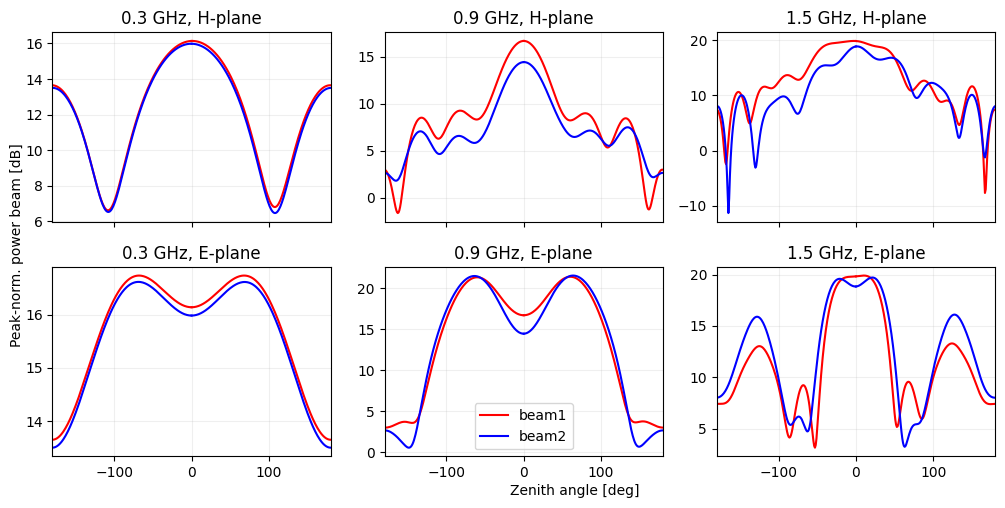

In [9]:
n_phi = len(beam1.axis1_array)
i_phi = 0 # change that to look at different azimuthal cuts
i_phi_2 = (i_phi + n_phi // 2 ) % n_phi # use this to plot both sides of the beam

fig,ax = plt.subplots(2,3,figsize=[10,5],sharex=True)


for i,i_freq in enumerate([0,len(beam1.freq_array)//2,-1]):
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[0,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi]), color='r', label='beam1')
    ax[0,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2]), color='r')

    # We need to rotate the second beam for it to align with the first
    ax[0,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi+n_phi//4) % n_phi]), color='b', label='beam2')
    ax[0,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi_2+n_phi//4) % n_phi]), color='b')

    
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))
    ax[1,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi + n_phi//4]), color='r', label='beam1')
    ax[1,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam1_power.data_array[0, 0, i_freq, :, i_phi_2 + n_phi//4]), color='r')

    # We need to rotate the second beam for it to align with the first
    ax[1,i].plot(beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi + n_phi//4+n_phi//4) % n_phi]), color='b', label='beam2')
    ax[1,i].plot(-beam1.axis2_array * 180/np.pi, 10 * np.log10(beam2_power.data_array[0, 0, i_freq, :, (i_phi_2 + n_phi//4+n_phi//4) % n_phi]), color='b')

    
    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)
ax[1,1].legend(loc='lower center',ncol=1)
fig.text(0.0,0.5,'Peak-norm. power beam [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
plt.tight_layout()

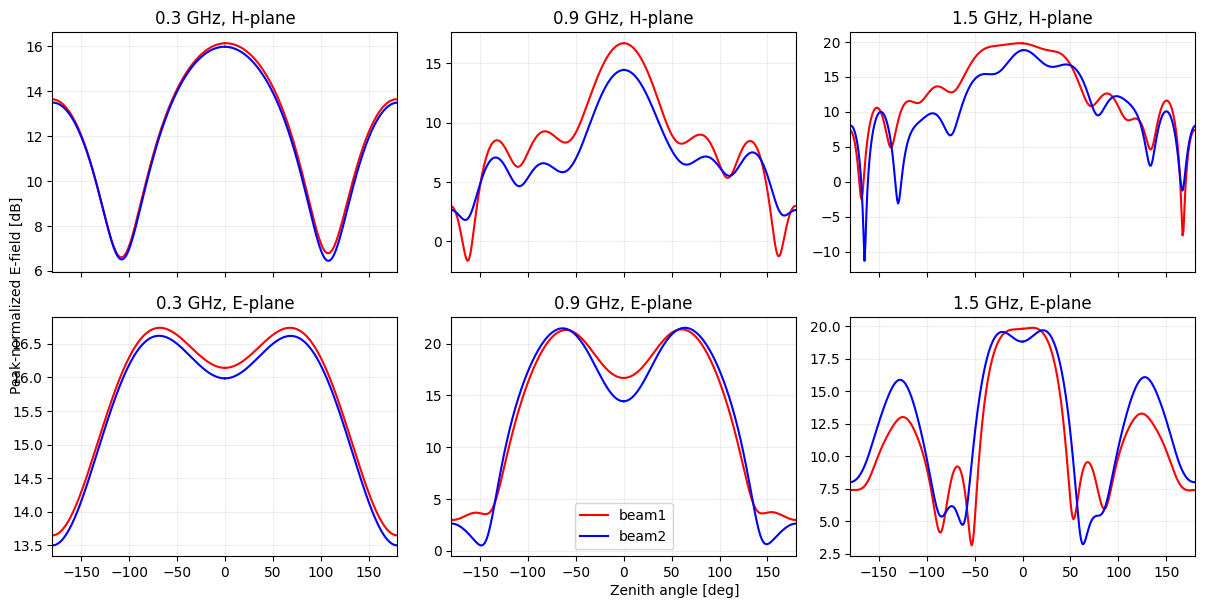

In [32]:
import numpy as np
import matplotlib.pyplot as plt

n_phi = len(beam1.axis1_array)
i_phi = 0  # base azimuth for beam1
i_phi_2 = (i_phi + n_phi // 2) % n_phi

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=False)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # first, middle, last frequencies

for i, i_freq in enumerate(freq_indices):

    # ---------- H-plane ----------
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1 magnitude
    theta = np.rad2deg(beam1.axis2_array)
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi]
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi]
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[0,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_2]
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_2]
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2 magnitude, rotated to align with beam1
    i_phi_b2 = (i_phi + n_phi//4) % n_phi
    i_phi_2_b2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_b2]
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_b2]
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[0,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_2_b2]
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_2_b2]
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # ---------- E-plane ----------
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1
    i_phi_e1 = (i_phi + n_phi//4) % n_phi
    i_phi_e1_2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi_e1]
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi_e1]
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[1,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_e1_2]
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_e1_2]
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2, rotated
    i_phi_e2 = (i_phi + n_phi//4 + n_phi//4) % n_phi
    i_phi_e2_2 = (i_phi_2 + n_phi//4 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_e2]
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_e2]
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[1,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_e2_2]
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_e2_2]
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # limits and grid
    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)

ax[1,1].legend(loc='lower center',ncol=1)
fig.text(0.0,0.5,'Peak-normalized E-field [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
plt.tight_layout()
plt.show()

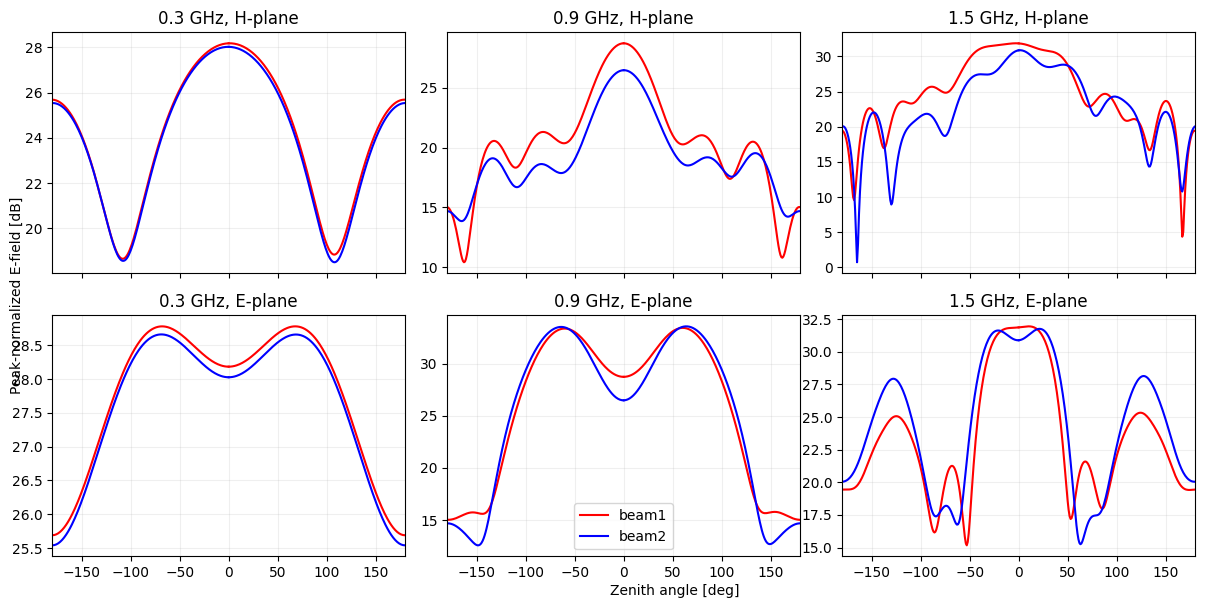

In [33]:
import numpy as np
import matplotlib.pyplot as plt

n_phi = len(beam1.axis1_array)
i_phi = 0  # base azimuth for beam1
i_phi_2 = (i_phi + n_phi // 2) % n_phi

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=False)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # first, middle, last frequencies

for i, i_freq in enumerate(freq_indices):

    # ---------- H-plane ----------
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1 magnitude
    theta = np.rad2deg(beam1.axis2_array)
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi]*4
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi]*4
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[0,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_2]*4
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_2]*4
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2 magnitude, rotated to align with beam1
    i_phi_b2 = (i_phi + n_phi//4) % n_phi
    i_phi_2_b2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_b2]*4
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_b2]*4
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[0,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_2_b2]*4
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_2_b2]*4
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # ---------- E-plane ----------
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1
    i_phi_e1 = (i_phi + n_phi//4) % n_phi
    i_phi_e1_2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi_e1]*4
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi_e1]*4
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[1,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_e1_2]*4
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_e1_2]*4
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2, rotated
    i_phi_e2 = (i_phi + n_phi//4 + n_phi//4) % n_phi
    i_phi_e2_2 = (i_phi_2 + n_phi//4 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_e2]*4
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_e2]*4
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[1,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_e2_2]*4
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_e2_2]*4
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # limits and grid
    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)

ax[1,1].legend(loc='lower center',ncol=1)
fig.text(0.0,0.5,'Peak-normalized E-field [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
plt.tight_layout()
plt.show()

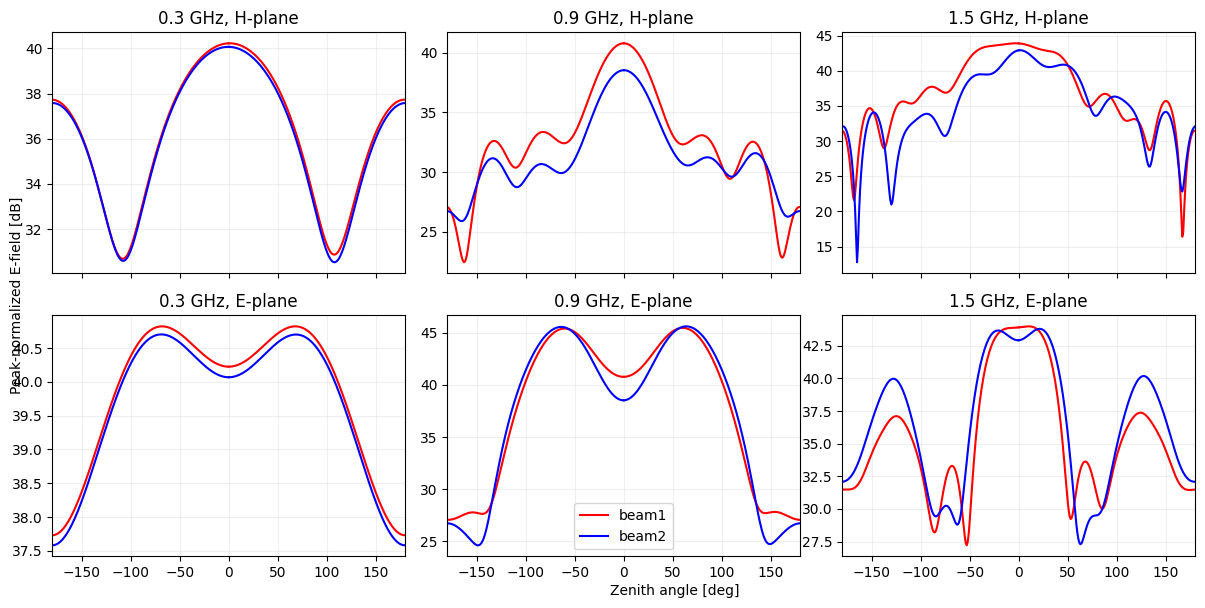

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n_phi = len(beam1.axis1_array)
i_phi = 0  # base azimuth for beam1
i_phi_2 = (i_phi + n_phi // 2) % n_phi

fig, ax = plt.subplots(2, 3, figsize=[12,6], sharex=True, sharey=False)

freq_indices = [0, len(beam1.freq_array)//2, -1]  # first, middle, last frequencies

for i, i_freq in enumerate(freq_indices):

    # ---------- H-plane ----------
    ax[0,i].set_title('{:.3g} GHz, H-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1 magnitude
    theta = np.rad2deg(beam1.axis2_array)
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi]*16
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi]*16
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[0,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_2]*16
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_2]*16
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2 magnitude, rotated to align with beam1
    i_phi_b2 = (i_phi + n_phi//4) % n_phi
    i_phi_2_b2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_b2]*16
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_b2]*16
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[0,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_2_b2]*16
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_2_b2]*16
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[0,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # ---------- E-plane ----------
    ax[1,i].set_title('{:.3g} GHz, E-plane'.format(beam1.freq_array[i_freq]*1e-9))

    # beam1
    i_phi_e1 = (i_phi + n_phi//4) % n_phi
    i_phi_e1_2 = (i_phi_2 + n_phi//4) % n_phi
    Eθ1 = beam1.data_array[0,0,i_freq,:,i_phi_e1]*16
    Eφ1 = beam1.data_array[1,0,i_freq,:,i_phi_e1]*16
    E1_mag = np.sqrt(np.abs(Eθ1)**2 + np.abs(Eφ1)**2)
    ax[1,i].plot(theta, 20*np.log10(E1_mag), color='r', label='beam1')

    Eθ1_b = beam1.data_array[0,0,i_freq,:,i_phi_e1_2]*16
    Eφ1_b = beam1.data_array[1,0,i_freq,:,i_phi_e1_2]*16
    E1b_mag = np.sqrt(np.abs(Eθ1_b)**2 + np.abs(Eφ1_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E1b_mag), color='r')

    # beam2, rotated
    i_phi_e2 = (i_phi + n_phi//4 + n_phi//4) % n_phi
    i_phi_e2_2 = (i_phi_2 + n_phi//4 + n_phi//4) % n_phi
    Eθ2 = beam2.data_array[0,0,i_freq,:,i_phi_e2]*16
    Eφ2 = beam2.data_array[1,0,i_freq,:,i_phi_e2]*16
    E2_mag = np.sqrt(np.abs(Eθ2)**2 + np.abs(Eφ2)**2)
    ax[1,i].plot(theta, 20*np.log10(E2_mag), color='b', label='beam2')

    Eθ2_b = beam2.data_array[0,0,i_freq,:,i_phi_e2_2]*16
    Eφ2_b = beam2.data_array[1,0,i_freq,:,i_phi_e2_2]*16
    E2b_mag = np.sqrt(np.abs(Eθ2_b)**2 + np.abs(Eφ2_b)**2)
    ax[1,i].plot(-theta, 20*np.log10(E2b_mag), color='b')


    # limits and grid
    for j in [0,1]:
        ax[j,i].set_xlim([-180,180])
        ax[j,i].grid(alpha=0.2)

ax[1,1].legend(loc='lower center',ncol=1)
fig.text(0.0,0.5,'Peak-normalized E-field [dB]',rotation=90,va='center')
fig.text(0.5,0,'Zenith angle [deg]')
plt.tight_layout()
plt.show()